# Sensitivity analysis and likelihood-based confidence regions

This tutorial is the implementation of the example given in the review paper published in *Energy and Buildings*:

[Rouchier S. (2018) Solving inverse problems in building physics: an overview of guidelines for a careful and optimal use of data. *Energy and Buildings*, DOI:10.1016/j.enbuild.2018.02.009](https://www.sciencedirect.com/science/article/pii/S0378778817317942)

## Introduction

This notebook follows the previous exercise on 2R2C model parameter estimation in a deterministic setting. We show how to run a sensitivity analysis on its parameters, and how to draw 2-dimensional likelihood-based confidence regions.

As in the previous notebook, we start by loading the data and defining the 2R2C model used for inference.

In [1]:
import pandas
import numpy as np
from scipy.linalg import expm
from numpy.linalg import inv

def dot3(A,B,C):
    """ Useful function that computes the dot product of three matrices"""
    return np.dot(A, np.dot(B,C))

dataset = pandas.read_csv('data01.csv')
time_ = np.array(dataset['Time'])
T_in  = np.array(dataset['T_int'])  # indoor temperature
T_ext = np.array(dataset['T_ext'])  # outdoor temperature
q     = np.array(dataset['q'])      # indoor prescribed heat

delta_t = time_[1] - time_[0]       # time step size
u = np.vstack([T_ext ,q]).T     # array of all inputs

def RC_model_simulation(time_, R1, R2, C1, C2, xe_0):
    
    # Matrices of the system in continuous form
    Ac = np.array([[-1/(C1*R1)-1/(C1*R2), 1/(C1*R2)],
                   [1/(C2*R2), -1/(C2*R2)]])
    Bc = np.array([[1/(C1*R1), 0],
                   [0, 1/C2]])
    
    # Matrices of the discretized state-space model
    F = expm(Ac*delta_t)
    G = dot3(inv(Ac), F-np.eye(2), Bc)
    H = np.array([[0, 1]])
    
    # Initialisation of the states
    x = np.zeros((len(time_), 2))
    x[0] = np.array((xe_0, T_in[0]))
    
    # Simulation
    for i in range(1,len(time_)):
        x[i] = np.dot(F, x[i-1]) + np.dot(G, u[i-1])
    
    # This function returns the second simulated state only
    return np.dot(H, x.T).flatten()

## Sensitivity analysis

A sensitivity analysis is a quick way to estimate the identifiability of a model's parameters, although it is not a sufficient condition for it. The following block of code is an example on how to use the [SALib](https://salib.readthedocs.io/en/latest/) library to run the FAST method.

In [2]:
problem = {'num_vars': 5,
           'names': ['R1', 'R2', 'C1', 'C2', 'xe_0'],
           'bounds': [[1e-2, 3e-2],
                      [1e-3, 3e-3],
                      [1e7, 2e7],
                      [1.5e6, 2.5e6],
                      [25, 35]]}

# Create a matrix of model inputs for the FAST method
from SALib.sample import fast_sampler
X = fast_sampler.sample(problem, 5000, M=4)
# Evaluate the output on each parameter of the sample
Y = np.zeros(len(X))
for i, theta in enumerate(X):
    y    = RC_model_simulation(time_, theta[0], theta[1], theta[2], theta[3], theta[4])
    Y[i] = np.sum((y-T_in)**2)
# Analyse and return sensitivity coefficients
from SALib.analyze import fast
sa_results = fast.analyze(problem, Y, M=4)

Running the code should get you roughly the same results as in the table below:

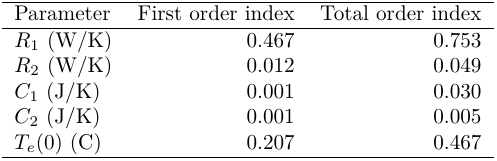

In [3]:
from IPython.display import Image
Image(filename='2R2C_sensitivity.png', width = 380)

## Likelihood-based confidence regions

In the first notebook, parameter estimation results showed some strong interactions between parameters. The highest correlation coefficient is between $R_2$ and $C_2$. This can be illustrated by likelihood-based confidence regions. A grid of $R_2-C_2$ values is first defined. On each point of the grid, the inverse problem is solved on all remaining parameters and the likelihood ratio function is calculated. This allows drawing two-dimensional likelihood-based confidence regions according: this is illustrated by the code below.

More details on this method are given in [the review paper](https://www.sciencedirect.com/science/article/pii/S0378778817317942).

First, we find the optimal value of all parameters as a reference:

In [4]:
from scipy.optimize import curve_fit

theta_init = [1e-2, 1e-2, 1e7, 1e7, 20]
popt, pcov = curve_fit(RC_model_simulation,
                       xdata = time_,
                       ydata = T_in,
                       p0 = theta_init,
                       method='lm')

# Calculating the indoor temperature predicted with the optimal parameters
T_in_opt = RC_model_simulation(time_, popt[0], popt[1], popt[2], popt[3], popt[4])
# Least square criterion for the optimal parameters
r_opt = np.sum((T_in_opt-T_in)**2)

The optimisation is then run sequentially on a grid of fixed values for $R_2$ and $C_2$, in order to display the likelihood profiles

In [ ]:
R2_vec = np.linspace(2e-3, 3e-3, num=50)
C2_vec = np.linspace(1e6, 3e6, num=50)
Ri, Ci = np.meshgrid(R2_vec, C2_vec)

# Series of optimizations where the R2 and C2 parameters are fixed
theta_init = [1e-2, 1e7, 20]
residuals = np.zeros_like(Ri.ravel())
for i in range(len(Ri.ravel())):
    
    def RC_model_simulation_R2C2fixed(time_, R1, C1, xe_0):
        return RC_model_simulation(time_, R1, Ri.ravel()[i], C1, Ci.ravel()[i], xe_0)
        
    popt, pcov = curve_fit(RC_model_simulation_R2C2fixed,
                           xdata = time_,
                           ydata = T_in,
                           p0 = theta_init,
                           method='lm')
    
    y    = RC_model_simulation(time_, popt[0], Ri.ravel()[i], popt[1],
                               Ci.ravel()[i], popt[2])
    residuals[i] = np.sum((y-T_in)**2)

# This is equivalent to the Likelihood ratio function
profile_likelihood = np.reshape((residuals-r_opt), (50,50))
# Quantiles of the chi2 distribution
percentiles = [0, 50, 75, 95, 99, 100]
levels = [ np.percentile(np.random.chisquare(2, size = 9000), q=_) 
            for _ in percentiles ]

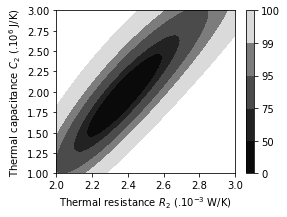

In [6]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4, 3))
cax = plt.contourf(Ri*1000, Ci/1e6, profile_likelihood,
                   levels = levels, cmap = 'Greys_r')
plt.xlabel('Thermal resistance $R_2$ (.$10^{-3}$ W/K)')
plt.ylabel('Thermal capacitance $C_2$ (.$10^6$ J/K)')
cbar = fig.colorbar(cax, ticks=levels)
cbar.ax.set_yticklabels(percentiles)